<a href="https://colab.research.google.com/github/luchonerv/FMAP/blob/main/FMAP_ARAMAYO_LUIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

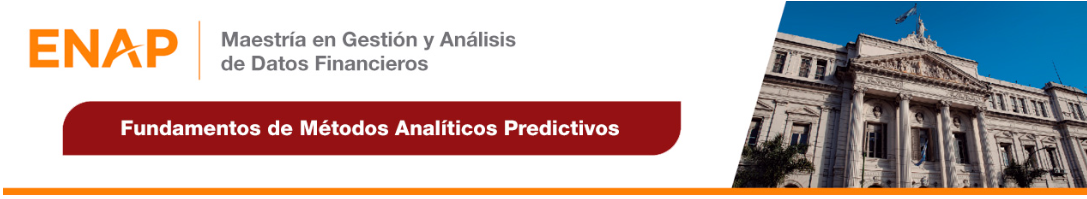

## **EVALUACION FINAL**

**Profesor**: Rodrigo Del Rosso - Patricia Girimonte

**Alumno**: Luis Aramayo

# **Librerias Necesarias**

In [ ]:
# Configuración - Manipulación de archivos
# ==============================================================================
import requests
import os
import warnings
import time

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,KFold,
                                     cross_val_score)
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

from scipy import stats
import statsmodels.api as sm
import statsmodels as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

# Configuración warnings
# ==============================================================================
warnings.filterwarnings('ignore')

# **Obtención de datos y categorización**

La base de datos fue obtenida a traves de un proceso de webscraping en la plataforma https://finviz.com/.

Repositorio del codigo implementado:https://github.com/luchonerv/FMAP


In [ ]:

# archivo data_nasaq.csv
Id_archivo = '10quoWHoOeIfOL4TgU1W14ykGOkU_O1OG'

# descarga
url = f"https://drive.google.com/uc?id={Id_archivo}"
response = requests.get(url)
with open(f'/content/data_nasdaq.csv', 'wb') as f:
    f.write(response.content)


# Leer el archivo CSV
df_nasdaq= pd.read_csv('data_nasdaq.csv', sep=';', decimal='.')

# Mostrar los primeros registros del DataFrame
df_nasdaq.head(5)

,symbol,Name,Sector,Market Cap,Cash/sh (mrq),P/S,P/C,EPS next Y,EPS this Y (%),SMA200 (%),...,52W Range Max,52W Range Min,52W High (%),Recom,Rel Volume,Perf Half Y (%),Perf Year (%),Beta,ATR (14),Target Price
0,FPI,Farmland Partners Inc. Common Stock,Real Estate,5.475800e+08,0.13,9.64,87.89,0.07,-90.57,2.34,...,9.79,13.06,-12.91,2.00,0.78,-3.05,7.71,0.76,0.22,12.88
1,CELC,Celcuity Inc. Common Stock,Health Care,5.234100e+08,5.69,NaN,2.95,-3.56,-2.29,21.89,...,8.39,22.19,-24.46,1.00,0.94,37.94,67.18,0.87,0.99,29.00
2,TSQ,Townsquare Media Inc. Class A Common Stock,Consumer Discretionary,1.746400e+08,3.74,0.39,3.09,1.20,157.97,11.48,...,8.00,13.57,-14.89,1.00,0.71,21.71,32.15,1.30,0.40,16.83
3,PTCT,PTC Therapeutics Inc. Common Stock,Health Care,2.540000e+09,11.54,2.74,2.87,-4.52,31.22,17.38,...,17.53,59.84,-44.69,2.79,0.74,59.34,-43.22,0.69,1.64,29.50
4,CENTA,Central Garden & Pet Company Class A Common St...,Consumer Discretionary,2.680000e+09,4.68,0.81,8.49,2.45,10.64,17.03,...,27.02,41.03,-3.17,1.57,1.68,20.63,39.11,0.76,1.08,46.00


In [ ]:
df_nasdaq.columns

Index(['symbol', 'Name', 'Sector', 'Market Cap', 'Cash/sh (mrq)', 'P/S', 'P/C',
       'EPS next Y', 'EPS this Y (%)', 'SMA200 (%)', 'Institutional Own (%)',
       'Institutional Trans (%)', 'ROA (%)', 'Oper-Margin (%)', 'Shs Outstand',
       'Shs Float', 'Short Interest', 'Avg Volume', 'Short Ratio',
       '52W Range Max', '52W Range Min', '52W High (%)', 'Recom', 'Rel Volume',
       'Perf Half Y (%)', 'Perf Year (%)', 'Beta', 'ATR (14)', 'Target Price'],
      dtype='object')

In [ ]:
#variables a considerar
variablesdep=['symbol', 'Name', 'Sector','52W Range Min','ATR (14)',
              '52W Range Max','52W High (%)',
              'Shs Outstand','Shs Float','Short Interest',
              'Rel Volume','Avg Volume',
              'SMA200 (%)','Institutional Trans (%)',
              'P/S','Cash/sh (mrq)',
              'Perf Year (%)','Perf Half Y (%)','EPS this Y (%)',
              'EPS next Y','Market Cap','ROA (%)','Institutional Own (%)',
              'Oper-Margin (%)','Recom',
              'Short Ratio','Beta','P/C',
              'Target Price']
df_nasdaq = df_nasdaq[variablesdep]

In [ ]:
df_nasdaq.shape

(3726, 29)

In [ ]:
# Columnas a convertir a categóricas

tipo_categorical =['symbol', 'Name', 'Sector','Recom']
# Convertir columnas categóricas
df_nasdaq[tipo_categorical] = df_nasdaq[tipo_categorical].astype('category')
df_nasdaq['sector_codes'] = df_nasdaq['Sector'].cat.codes.astype('category')

# agregar a la lista la columna sector_codes
tipo_categorical.append('sector_codes')
# Convertir el resto de las columnas a tipo float
columnas_resto = df_nasdaq.columns.difference(tipo_categorical)
df_nasdaq[columnas_resto]=df_nasdaq[columnas_resto].replace(0,np.nan)
df_nasdaq[columnas_resto] = df_nasdaq[columnas_resto].astype(float)




In [ ]:
df_nasdaq.shape

(3726, 30)

In [ ]:
df_nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726 entries, 0 to 3725
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   symbol                   3726 non-null   category
 1   Name                     3726 non-null   category
 2   Sector                   3726 non-null   category
 3   52W Range Min            3726 non-null   float64 
 4   ATR (14)                 3726 non-null   float64 
 5   52W Range Max            3726 non-null   float64 
 6   52W High (%)             3723 non-null   float64 
 7   Shs Outstand             3722 non-null   float64 
 8   Shs Float                3694 non-null   float64 
 9   Short Interest           3680 non-null   float64 
 10  Rel Volume               3725 non-null   float64 
 11  Avg Volume               3722 non-null   float64 
 12  SMA200 (%)               3725 non-null   float64 
 13  Institutional Trans (%)  3481 non-null   float64 
 14  P/S     

In [ ]:
# Obtener los tipos de datos de cada columna
tipos_de_datos = df_nasdaq.dtypes
# Contar los tipos de datos
conteo_tipos = tipos_de_datos.value_counts()
# Imprimir el resultado
print(conteo_tipos)


float64     25
category     1
category     1
category     1
category     1
category     1
Name: count, dtype: int64


# **1- Imputación de datos faltantes**


Evaluar la cantidad de datos faltantes en el dataset, tanto a nivel columna como a nivel fila.
Si el conjunto de datos elegido no tiene datos faltantes lo que sigue no se realiza.
Para el caso de datos faltantes por columnas indicar el porcentaje de registros que cumplen esta condición.
Con respecto a datos faltantes a nivel columna, calcular la distribución de la cantidad de columnas con datos
faltantes por fila.
Proponer y aplicar técnicas para completarlos.
Mostrar gráficamente la distribución de la variable antes y después de realizar la imputación.

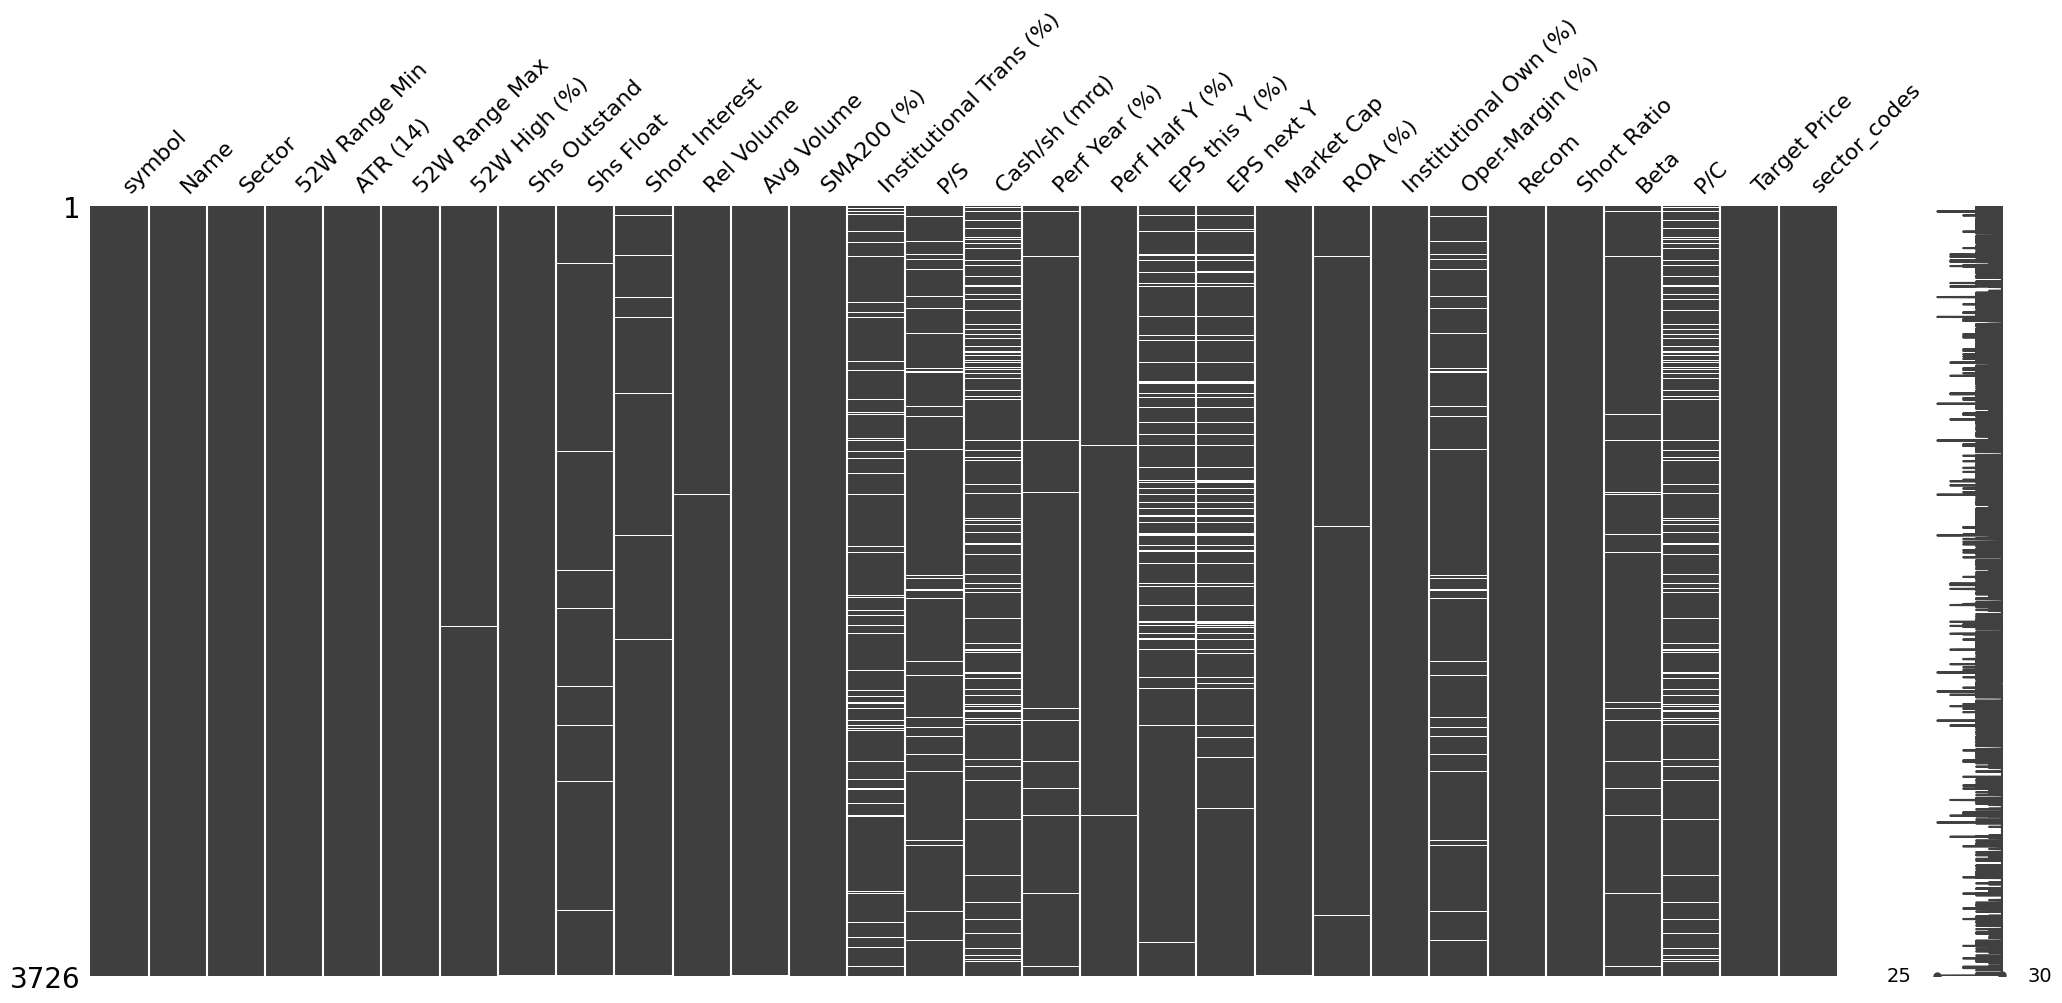

In [ ]:
# Crear el gráfico de valores perdidos
msno.matrix(df_nasdaq)

# Mostrar el gráfico
plt.show()

In [ ]:
def valores_faltantes(df):

    # Contar los valores faltantes en cada columna
    valores_faltantes = df.isnull().sum()

    # Calcular el porcentaje de valores faltantes
    porcentaje_faltantes = round((df.isnull().sum() / len(df)) * 100,2)
    cantidad_registros = df.shape[0]*df.shape[1]

    # Crear un DataFrame con los datos de valores faltantes y porcentaje de valores faltantes
    df_valores_faltantes = pd.DataFrame({'Valores Faltantes': valores_faltantes,
                                        '%': porcentaje_faltantes})
    df_valores_faltantes.reset_index(inplace=True)
    df_valores_faltantes= df_valores_faltantes[df_valores_faltantes['Valores Faltantes'] > 0]
    cantidad_total_cols = df.shape[1]
    columns_falts = df_valores_faltantes.shape[0]
    print('CONJUNTO DE DATOS\n')
    print(f'Total de columnas: {cantidad_total_cols}')
    print(f'Total de filas: {df.shape[0]}')
    print(f'Registros totales: {cantidad_registros}\n')

    print(f'Cantidad de columnas con valores faltantes:{columns_falts}')
    print(f'Suma total de valores faltantes: '
      f'{df_valores_faltantes["Valores Faltantes"].sum()}')
    print(f'Porcentaje total de valores faltantes: '
      f'{df_valores_faltantes["Valores Faltantes"].sum() / cantidad_registros * 100:.2f}%\n')
      # seleccionar aquellos indicadores donde el % de valores faltantes sea
      ## mayor a 10%
    eliminar = df_valores_faltantes.loc[df_valores_faltantes['%'] > 10, 'index'].tolist()
    print('Columnas con más del 10% de valores faltantes:')
    if not eliminar:
        print(' - No existen Columnas a eliminar')
    else:
        print(df_valores_faltantes.loc[df_valores_faltantes['%'] > 10])


    col_faltantes = df.columns[df.isnull().any()].tolist()
    col_faltantes = [col for col in col_faltantes if col not in eliminar]

    return (eliminar,      # contiene listado de columnas a eliminar
            col_faltantes) # contiene listado de columnas con faltantes

df = df_nasdaq.copy()

lista_eliminar, col_faltantes = valores_faltantes(df)

CONJUNTO DE DATOS

Total de columnas: 30
Total de filas: 3726
Registros totales: 111780

Cantidad de columnas con valores faltantes:21
Suma total de valores faltantes: 2063
Porcentaje total de valores faltantes: 1.85%

Columnas con más del 10% de valores faltantes:
            index  Valores Faltantes      %
15  Cash/sh (mrq)                375  10.06


In [ ]:
# eliminar de df las columnas seleccionadas
# Imprimir la lista de elementos
print('Eliminados:')
print('\n'.join([f'{i+1}. {item}' for i, item in enumerate(lista_eliminar)]))
df = df.drop(columns=lista_eliminar)
# Crear el gráfico de valores faltantes con las columnas con faltantes
print('\nColumnas que permanecen en el conjunto de datos con valores faltantes')
# msno.matrix(df[col_faltantes])
# plt.show()

Eliminados:
1. Cash/sh (mrq)

Columnas que permanecen en el conjunto de datos con valores faltantes


In [ ]:
cols_faltantes = valores_faltantes(df)
# Calcular un umbral del 10% de valores faltantes en filas
umbral = df.shape[1] * 0.1

# Encontrar las filas con más del 10% de valores faltantes
row_valfaltantes = df[df.isnull().sum(axis=1) > umbral]

# Contar la cantidad de filas con más del 10% de valores faltantes
cant_row_valfaltantes = len(row_valfaltantes)

# Calcular el porcentaje de filas con más del 10% de valores faltantes
porc_row_valfaltantes = (cant_row_valfaltantes / df.shape[0]) * 100

# Mostrar la cantidad y el porcentaje de filas con más del 10% de valores faltantes
print("\nFilas con más del 10% de valores faltantes: {} ({:.2f}%)"
.format(cant_row_valfaltantes, porc_row_valfaltantes))

# msno.matrix(df)
# plt.show()

CONJUNTO DE DATOS

Total de columnas: 29
Total de filas: 3726
Registros totales: 108054

Cantidad de columnas con valores faltantes:20
Suma total de valores faltantes: 1688
Porcentaje total de valores faltantes: 1.56%

Columnas con más del 10% de valores faltantes:
 - No existen Columnas a eliminar

Filas con más del 10% de valores faltantes: 127 (3.41%)


In [ ]:
# Imputar Valores faltantes
# crear una copia para imputar valores faltantes
df_imp = df.iloc[:, 3:].copy()
# Imputación de valores faltantes por criterio de distancia con KNNImputer
imp=KNNImputer(n_neighbors=2, weights='distance')
# Imputar los valores faltantes en las columnas seleccionadas
df_imp[col_faltantes] = imp.fit_transform(df_imp[col_faltantes])

#Mostrar el gráfico de valores faltantes (valores imputados)
# msno.matrix(df_imp)
# plt.show()

# **2 - Analisis Exploratorio de variables**

Variables a Analizar:
1.- Sector
2.- Market Cap
3.- Avg Volume
4.- Target Price

Sector
Conteo de Sectores y porcentaje de participación:
Consumer Discretionary: 766 (20.56%)
Health Care: 714 (19.16%)
Finance: 547 (14.68%)
Technology: 536 (14.39%)
Industrials: 404 (10.84%)
Real Estate: 199 (5.34%)
Energy: 130 (3.49%)
Utilities: 116 (3.11%)
Miscellaneous: 103 (2.76%)
Consumer Staples: 90 (2.42%)
Telecommunications: 62 (1.66%)
Basic Materials: 59 (1.58%)

Market Cap - Avg Volume


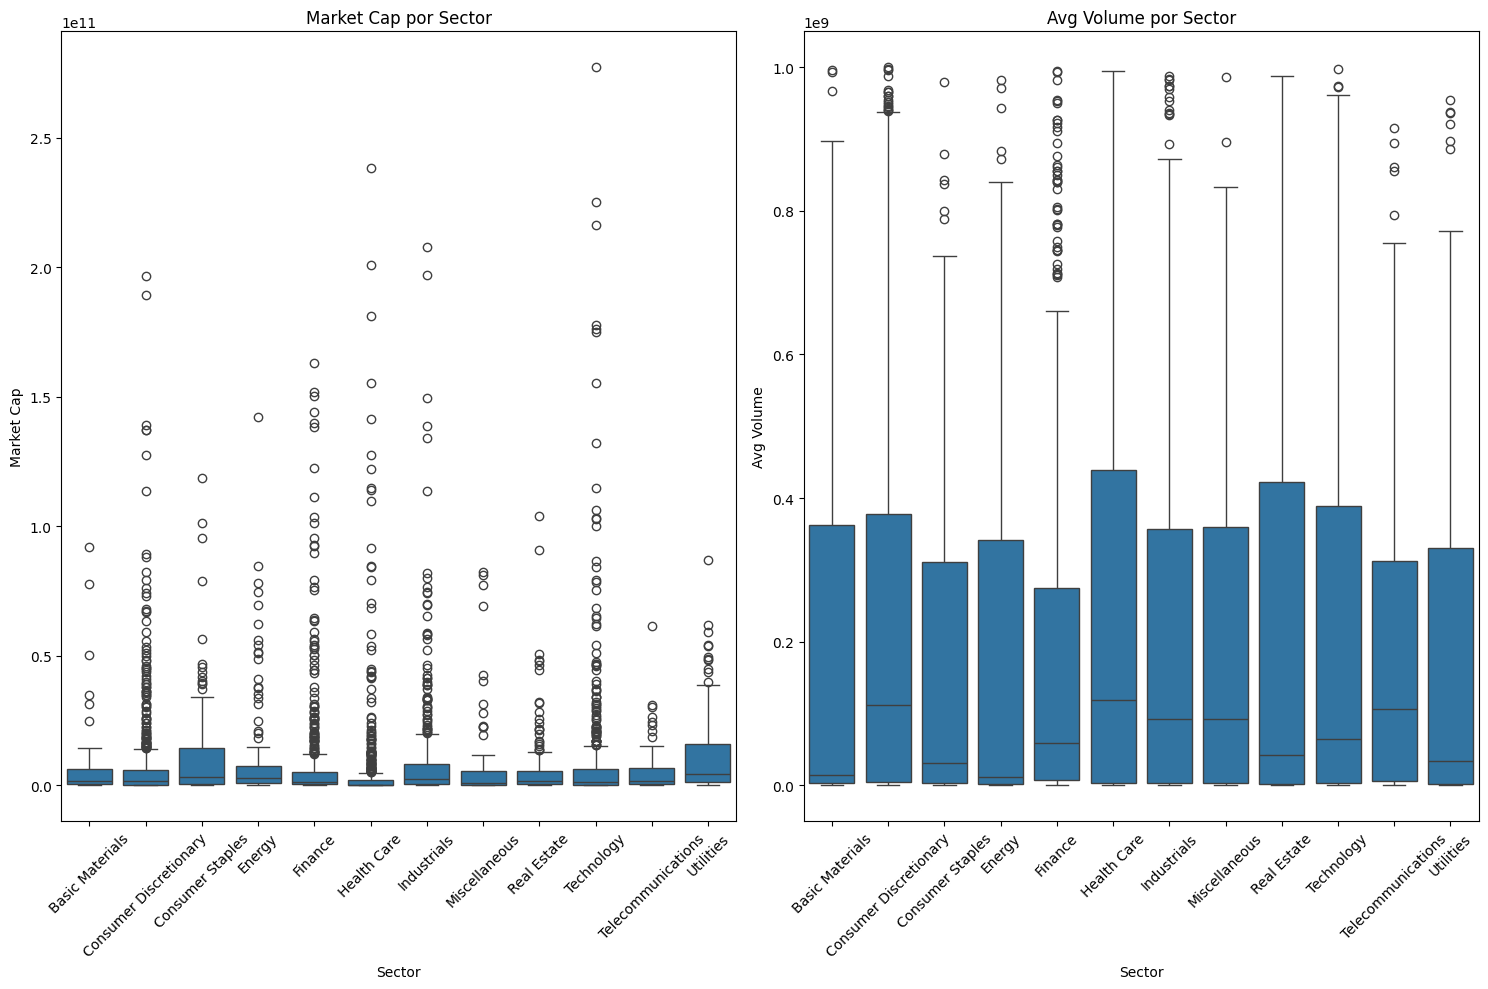

Descripción Market Cap:
                         count mean  std   min   25%   50%  75%   max
Sector                                                               
Basic Materials          59.00   8B  17B    7M  663M    2B   6B   92B
Consumer Discretionary  765.00   7B  19B    3M  323M    2B   6B  196B
Consumer Staples         90.00  13B  23B    2M  650M    3B  14B  119B
Energy                  130.00  11B  21B   20M  735M    3B   8B  142B
Finance                 547.00   9B  22B    2M  350M    1B   5B  163B
Health Care             714.00   5B  20B  980K   71M  343M   2B  238B
Industrials             404.00  10B  23B    2M  369M    2B   8B  208B
Miscellaneous           103.00   7B  16B    7M  256M    1B   6B   83B
Real Estate             199.00   6B  13B    2M  532M    2B   6B  104B
Technology              534.00  10B  28B    1M  233M    1B   6B  277B
Telecommunications       62.00   6B  11B    7M  353M    2B   7B   61B
Utilities               115.00  12B  17B    9M    1B    4B  16B   

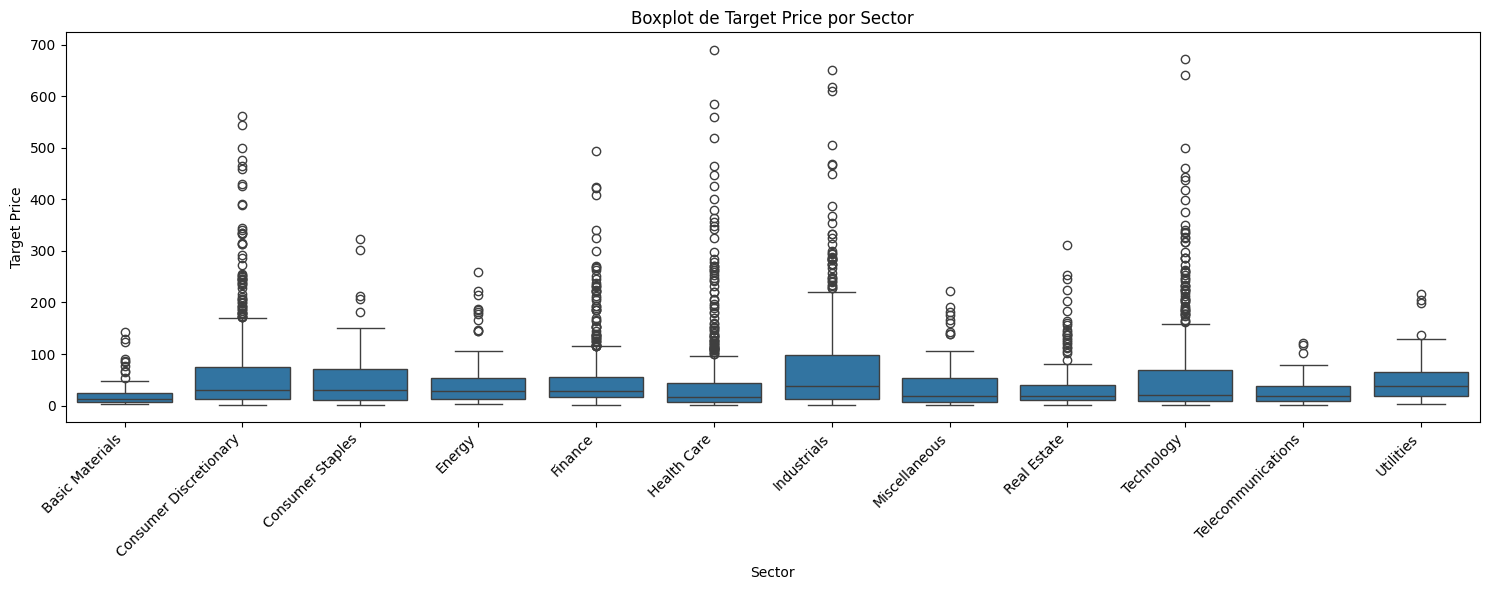

In [ ]:
# Función para formatear la salida númerica
def format_num(x):
  if x < 1e3:
   return '{:.2f}'.format(x)
  elif x < 1e6:
    return f"{x / 1e3:.0f}K"
  elif x < 1e9:
    return f"{x / 1e6:.0f}M"
  else:
    return f"{x / 1e9:.0f}B"


 # Selección de dos variables numéricas y una categórica:
df_descr = df[['symbol','Sector','Market Cap','Avg Volume','Target Price',
               'sector_codes']].copy()

print('Variables a Analizar:\n1.- Sector\n2.- Market Cap\n'
      '3.- Avg Volume\n4.- Target Price\n')


print('='*80 + '\n' + 'Sector' + '\n' + '='*80)
# Descripción de Sectores
 ## Conteo de Sectores en el conjunto de datos
sector_counts = df_descr['Sector'].value_counts()
 ## Calcular el porcentaje de participación de cada sector
sector_percentages = (sector_counts / df_descr.shape[0]) * 100

 ## Imprimir el conteo de sectores y sus porcentajes
print("Conteo de Sectores y porcentaje de participación:")
for sector, count, percentage in zip(sector_counts.index,
                                     sector_counts.values,
                                     sector_percentages.values):
    print(f"{sector}: {count} ({percentage:.2f}%)")


# Estadisticas descriptivas:
df_mc = df_descr.groupby('Sector')['Market Cap'].describe()
df_pe = df_descr.groupby('Sector')['Avg Volume'].describe()
df_tp = df_descr.groupby('Sector')['Target Price'].describe()
df_tp = df_tp.round(0)

# Aplicar la función format_num a los valores de salida
df_mc_f= df_mc.applymap(format_num)
df_pe_f= df_pe.applymap(format_num)

print('\n' + '='*80 + '\n' + 'Market Cap - Avg Volume' + '\n' + '='*80)

# Boxplot de variables por sector.
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,10))

#boxplot Market Cap:
sns.boxplot(x='Sector',y='Market Cap',data=df_descr ,ax=ax1)
ax1.tick_params(axis='x',rotation=45)
ax1.set_title('Market Cap por Sector')

#boxplot Volumen:
sns.boxplot(x='Sector',y='Avg Volume',data=df_descr ,ax=ax2)
ax2.tick_params(axis='x',rotation=45)
ax2.set_title('Avg Volume por Sector')

# Ajustar diseño y mostrar gráficos
plt.tight_layout()
plt.show()

# Estadísticas descriptivas:
print("Descripción Market Cap:")
print('='*80 + '\n' + str(df_mc_f) + '\n' + '='*80)
print("\nDescripción Avg Volume:")
print(str(df_pe_f) + '\n' + '='*80+'\n')


print('\n' + '='*80 + '\n' + 'Target Price' + '\n' + '='*80)
# Analizar la variable target:
# Estadísticas descriptivas:
print("\nDescripción Target Price:")
print(str(df_tp) + '\n' + '='*80+'\n')

# Boxplot de 'Target Price' categorizado por 'Sector'
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df_descr, x='Sector', y='Target Price', ax=ax)
ax.set_title('Boxplot de Target Price por Sector')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Ajustar diseño y mostrar gráfico
plt.tight_layout()
plt.show()




El análisis del indicador 'Target Price' revela una considerable dispersión en los datos, con desviaciones estándar que, en muchos casos, superan los precios promedio. Esto, junto con medianas generalmente inferiores a las medias, sugiere una distribución asimétrica hacia la derecha, donde unos pocos valores altos influyen significativamente en el promedio. Este hecho se verifica a traves del gráfico boxplot donde se pueden observar la gran existencia de valores outliers, en todos los sectores pero destacandose en 'Technology', 'healthcare', 'finance' y 'consumer discretionary'.

El hecho de que los precios promedio no superen el tercer cuartil (75%) en la mayoría de los sectores refuerza esta idea, indicando que existen pocas empresas con precios muy elevados que elevan la precio promedio, mientras que la mayoría se concentra en valores más bajos.

En términos de 'precios máximos', los sectores de "Technology", "Health Care" e "Industrials" presentan los precios más altos, tanto , mientras que "Basic Materials" y "Telecomunicaciones" son los sectores que menos se destacan.

La dispersión y asimetría observadas en la variable objetivo también se manifiestan en los indicadores 'Market Cap' y 'Avg Volume', lo cual es esperable dada la heterogeneidad de las empresas que cotizan en el NASDAQ, con capitalizaciones de mercado que abarcan desde el millon de dolares,  hasta los 240 billones de dólares. Esta amplia variabilidad, junto con la presencia de valores atípicos (outliers) en cada sector,  van a ser los efectos a tratar de disminuir, o manejar de la manera más acorde para que no afecten a el desempeño de los modelos predictivos a aplicar.


#**3 - Aplicación de Modelos Predictivos**

## *Funciones*

**Función de Medicion de tiempo**

In [ ]:
# Función para medir el tiempo de ejecución:
def tiempo(start_time,end_time):
  # Calcular el tiempo transcurrido en minutos
  elapsed_time = (end_time - start_time)/60
  print(f"\nTiempo de ejecución: {elapsed_time:.2f} minutos")
  return

**Función de Cross Validation**

In [ ]:
def cross_validation(model, x, y, cv):

    # Definir el método de cross-validation
    kf = KFold(n_splits=cv, shuffle=True, random_state=2024)

    # Convertir los datos a arrays de numpy
    x_pvalue_np = x.values
    y_np = y.values
    # Titulo
    if isinstance(model, xgb.XGBRegressor):
	    print('')
    else:
      print(f'\nModelo: {model}')
    # Aplicar validación cruzada con cv folds para MSE
    cv_mse_scores = cross_val_score(model, x_pvalue_np, y_np, cv=kf,
                                    scoring='neg_mean_squared_error')
    cv_mse_scores = -cv_mse_scores

    # Calcular la media y el desvío estándar de los scores de MSE
    #mse_scores = np.around(np.array(cv_mse_scores),2)
    mean_mse_score = round(np.mean(cv_mse_scores),2)
    std_mse_score = round(np.std(cv_mse_scores),2)

    # Aplicar validación cruzada con cv folds para R2
    cv_r2_scores = cross_val_score(model, x, y, cv=kf, scoring='r2')

    # Calcular la media y el desvío estándar de los scores de R2
    #scores_r2_np = np.around(np.array(cv_r2_scores),2)
    mean_r2_score = round(np.mean(cv_r2_scores), 2)
    std_r2_score = round(np.std(cv_r2_scores), 2)

    # Imprimir métricas de validación cruzada
    print(f"\nValidación Cruzada con cv = {cv}"+ '\n' + '='*45)
    print("\nR²:")
    #print("Scores de validación cruzada (R²):", scores_r2_np)
    print("Promedio de scores (R²):",mean_r2_score)
    print("Desvío estándar de scores (R²):",std_r2_score)
    print("\nMSE:")
    #print("Scores de validación cruzada (MSE):", mse_scores)
    print("Promedio de scores(MSE):", mean_mse_score)
    print("Desvío estándar de scores (MSE):", std_mse_score)



**Función Grafico Desempeño de modelo**

In [ ]:
def grafico_desempeño (y, y_pred_train,y_test, y_pred_test):
  plt.figure(figsize=(8, 5))
  # Gráfico de valores de entrenamiento
  plt.subplot(1, 2, 1)

  plt.scatter(y, y_pred_train, alpha=0.5, color='red',
              label='Valores Predichos (Entrenamiento)')
  plt.scatter(y, y, alpha=0.5, color='blue',
              label='Valores Verdaderos (Entrenamiento)')


  plt.xlabel('Valores reales')
  plt.ylabel('Predicciones')
  plt.title('Predicciones vs. Valores Reales (Entrenamiento)')
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
             shadow=True, ncol=1)
  plt.grid(True, alpha=0.3)


  # Gráfico de valores de prueba
  plt.subplot(1, 2, 2)

  plt.scatter(y_test, y_pred_test, alpha=0.5, color='red',
              label='Valores Predichos (Prueba)')
  plt.scatter(y_test, y_test, alpha=0.5, color='blue',
              label='Valores Verdaderos (Prueba)')

  plt.xlabel('Valores reales')
  plt.ylabel('Predicciones')
  plt.title('Predicciones vs. Valores Reales (Prueba)')
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
             shadow=True, ncol=1)
  plt.grid(True, alpha=0.3)


  plt.tight_layout()
  plt.show()
  return None



**Funcion Métricas**

In [ ]:
def metricas_mod(modelo,y,y_pred1_train,y_test,y_pred1_test,oob=None):
  print(f"\nDESEMPEÑO {modelo}:")
  print("-" * 80)  # Línea divisoria

  #-------Entrenamiento---------------#
    # Calculos de metricas:
  mse_train = mean_squared_error(y,y_pred1_train)
  mae_train = mean_absolute_error(y,y_pred1_train)
  r2_train=r2_score(y,y_pred1_train)

  print('Sobre el conjunto de entrenamiento\n')
  print(f"R²: {r2_train:.3f}")
  print(f"Error cuadrático medio (MSE): {mse_train:.2f}")
  print(f"Error absoluto medio (MAE): {mae_train:.2f}")
  # Imprimir OOB Score solo si fue proporcionado
  if oob is not None:
    print(f'OOB Score: {oob:.2f}')


  # Calculos de metricas:
  r2=r2_score(y_test,y_pred1_test)
  # Error cuadrático medio
  mse = mean_squared_error(y_test,y_pred1_test)
  # Error medio absoluto
  mae = mean_absolute_error(y_test,y_pred1_test)

  #-------Prueba---------------#
  print('\nSobre el conjunto de Prueba\n')
  print(f"R²: {r2:.3f}")
  print(f"Error cuadrático medio (MSE): {mse:.2f}")
  print(f"Error absoluto medio (MAE): {mae:.2f}")

    # gráficos de los desempeños del modelo 1 y 2
  print("\nCOMPARACIÓN VALORES REALES VS PREDICCIONES")
  print("-" * 80)
  grafico_desempeño(y,y_pred1_train,y_test,y_pred1_test)
  return None

# **Regresion Lineal Multiple**

## *Eliminacion de Outliers*

In [ ]:
# Aplicar Isolation Forest para identificar outliers
df2= df_imp.copy()
# Establecer deteccion de 20% de outliers
isolation_forest = IsolationForest(contamination=0.20,
                                   random_state=2024)
outliers = isolation_forest.fit_predict(df2)

print(f"DataFrame original:{df2.shape}")

# Agregar una nueva columna 'Outlier' al DataFrame
# outliers será 1 para los puntos normales y -1 para los outliers
df2['Outlier'] = outliers

# Eliminar los outliers del DataFrame
df_sin_outliers = df2[df2['Outlier'] == 1].drop('Outlier', axis=1)

print(f"\nDataFrame sin outliers:{df_sin_outliers.shape}\n")

print(f'Cantidad de registros eliminados:{df.shape[0]-df_sin_outliers.shape[0]}')

DataFrame original:(3726, 26)

DataFrame sin outliers:(2981, 26)

Cantidad de registros eliminados:745


## *Multicolinealidad*

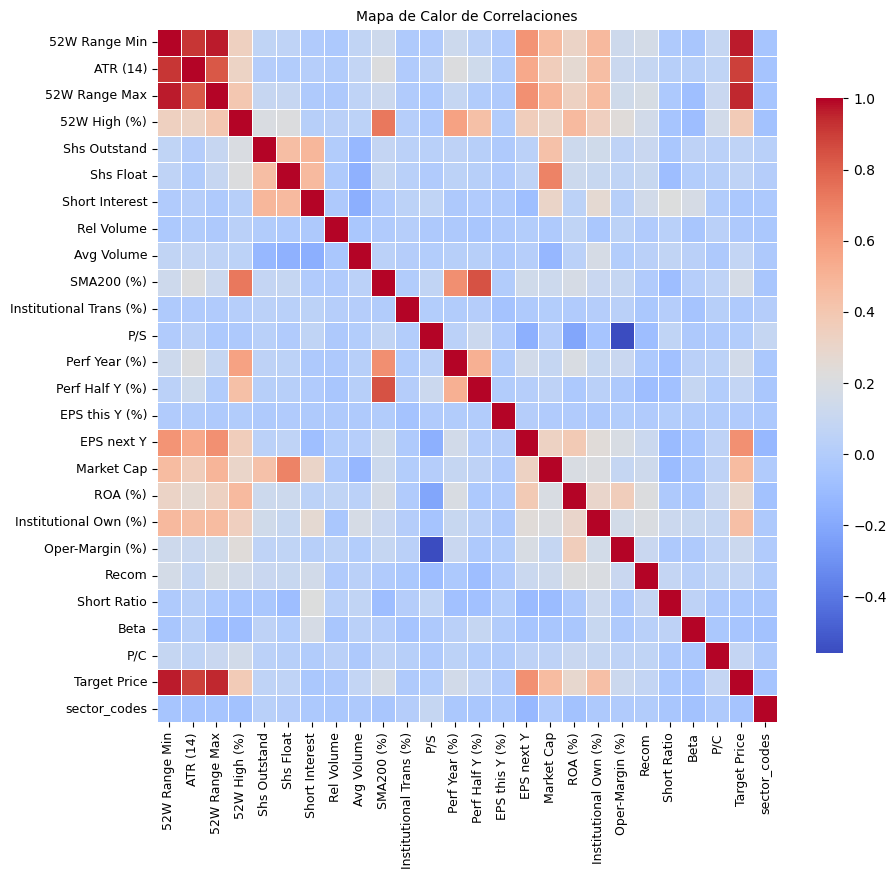

In [ ]:
# Calcular la matriz de correlaciones

correlation_matrix = df_sin_outliers.corr()

# Crear el mapa de calor usando seaborn
plt.figure(figsize=(10, 9))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5,
            cbar_kws={'shrink': .8}, annot_kws={"size": 8})

# Añadir título
plt.title('Mapa de Calor de Correlaciones', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

SE observa en el mapa de calor la alta correlación entre las siguientes variables:
 - '52W Range Min', '52W Range Max' y 'ATR (14)'

 - 'Shs Outstand' y 'Shs Float'

_________________

**VIF (variance inflation Factor):** cuantificación de la intensidad de la multicolinealidad en el modelo de regresion .

Pautas a considerar:

 - VIF <5: Multicolinealidad muy baja
 - 5< VIF <10: Multicolinealidad moderada. puede ser aceptable,
 - VIF >10: Alta multicolinealidad, considerar eliminación de la variable.

In [ ]:
# Calculo del factor de inflación de la varianza:

def calcular_vif(x):
    vif_data = pd.DataFrame()
    vif_data['Indicadores'] = x.columns
    vif_data['VIF'] = [variance_inflation_factor(x.values,i) for i in range (x.shape[1])]
    print(f'vif_results:\n{vif_data}')
    mayor = (vif_data['VIF']>5).sum()
    print(f'\n Indicadores con VIF mayores a 5: {mayor}')
    return


# Variables independientes
x_orig2= df_sin_outliers.drop(['Target Price'], axis=1)
# resultados de VIF
calcular_vif(x_orig2)


vif_results:
                Indicadores        VIF
0             52W Range Min  94.098726
1                  ATR (14)  21.538187
2             52W Range Max  46.754205
3              52W High (%)   8.080320
4              Shs Outstand   2.541312
5                 Shs Float   3.446833
6            Short Interest   2.824059
7                Rel Volume   2.967894
8                Avg Volume   1.841444
9                SMA200 (%)   8.401089
10  Institutional Trans (%)   1.019678
11                      P/S   2.010701
12            Perf Year (%)   2.018708
13          Perf Half Y (%)   5.579025
14           EPS this Y (%)   1.007187
15               EPS next Y   2.892453
16               Market Cap   3.918660
17                  ROA (%)   1.710573
18    Institutional Own (%)   7.136418
19          Oper-Margin (%)   1.686948
20                    Recom   6.976791
21              Short Ratio   2.580909
22                     Beta   5.223866
23                      P/C   1.167902
24          

In [ ]:
columnas_eliminar=['52W Range Max','ATR (14)','Shs Float','SMA200 (%)']

# Seleción de resultados menores a 10
x_orig2 = x_orig2.drop(columns = columnas_eliminar)

# Verificar resultados de VIF
calcular_vif(x_orig2)

vif_results:
                Indicadores       VIF
0             52W Range Min  4.751045
1              52W High (%)  4.520874
2              Shs Outstand  2.508390
3            Short Interest  2.580765
4                Rel Volume  2.874286
5                Avg Volume  1.833785
6   Institutional Trans (%)  1.017407
7                       P/S  1.998097
8             Perf Year (%)  1.795439
9           Perf Half Y (%)  1.790635
10           EPS this Y (%)  1.006334
11               EPS next Y  2.820367
12               Market Cap  2.167729
13                  ROA (%)  1.688168
14    Institutional Own (%)  7.071287
15          Oper-Margin (%)  1.683283
16                    Recom  6.539018
17              Short Ratio  2.543990
18                     Beta  5.112080
19                      P/C  1.163388
20             sector_codes  3.566749

 Indicadores con VIF mayores a 5: 3


## *MODELO 1:*

### *Datos de entrenamiento*

In [ ]:
# datos
  ## Se utiliza el dataframe sin outliers
  # Variables independientes
x_orig2
  # Variable target: 'Target Price'
y_orig2 = pd.Series(df_sin_outliers['Target Price'])

x, x_test, y, y_test = train_test_split(x_orig2, y_orig2,
                                        test_size=0.25,
                                        random_state=2024)

### *Entrenamiento y Resultados*

In [ ]:
# Entrenar el modelo:
x_constant1 = sm.add_constant(x)
model = sm.OLS(y, x_constant1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Target Price   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1730.
Date:                Sat, 25 May 2024   Prob (F-statistic):               0.00
Time:                        07:39:51   Log-Likelihood:                -8224.2
No. Observations:                2235   AIC:                         1.649e+04
Df Residuals:                    2213   BIC:                         1.662e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      13.6695      1.139     12.000      0.000      11.436      15.903
52W Range Min               0.9203      0.008    116.598      0.000       0.905       0.936
52W High (%)                0.1594      0.016     10.128      0.000       0.129       0.190
Shs Outstand             -2.24e-12   2.16e-12     -1.038      0.299   -6.47e-12    1.99e-12
Short Interest          -1.731e-08   4.99e-08     -0.347      0.729   -1.15e-07    8.06e-08
Rel Volume                  0.4628      0.376      1.232      0.218      -0.274       1.199
Avg Volume               2.371e-09   8.29e-10      2.859      0.004    7.45e-10       4e-09
Institutional Trans (%)    -0.0075      0.017     -0.452      0.651      -0.040       0.025
P/S                         0.0135      0.040      0.337      0.736      -0.065       0.092
Perf Year (%)              -0.0054      0.005     -1.055      0.292      -0.015       0.005
Perf Half Y (%)            -0.0035      0.008     -0.444      0.657      -0.019       0.012
EPS this Y (%)             -0.0004      0.001     -0.633      0.527      -0.001       0.001
EPS next Y                  0.5419      0.088      6.186      0.000       0.370       0.714
Market Cap               1.019e-10   2.85e-11      3.570      0.000    4.59e-11    1.58e-10
ROA (%)                    -0.0753      0.012     -6.160      0.000      -0.099      -0.051
Institutional Own (%)      -0.0231      0.009     -2.712      0.007      -0.040      -0.006
Oper-Margin (%)            -0.0033      0.002     -2.040      0.041      -0.007      -0.000
Recom                      -4.4109      0.295    -14.943      0.000      -4.990      -3.832
Short Ratio                 0.0281      0.059      0.474      0.635      -0.088       0.144
Beta                        0.3530      0.359      0.983      0.325      -0.351       1.057
P/C                        -0.0022      0.003     -0.854      0.393      -0.007       0.003
sector_codes               -0.1357      0.072     -1.897      0.058      -0.276       0.005
==============================================================================
Omnibus:                     2709.654   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1046628.096
Skew:                           5.898   Prob(JB):                         0.00
Kurtosis:                     108.356   Cond. No.                     8.59e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Valores bajos de P>|t| (por ejemplo, menos de 0.05):
Se considera que la variable independiente tiene un efecto significativo sobre la variable dependiente.
Es poco probable que el coeficiente de regresión observado se deba al azar.
Se puede rechazar la hipótesis nula de que el coeficiente de regresión es igual a cero.

Es importante destacar que:

La significancia estadística no implica necesariamente una relación causal.
Se deben considerar otros factores y realizar análisis adicionales para confirmar la existencia de una relación causal entre las variables.
El valor de corte común para la significancia estadística es de 0.05, pero este valor puede variar según el contexto del caso a analizar.



DESEMPEÑO (Modelo 1):
--------------------------------------------------------------------------------
Sobre el conjunto de entrenamiento

R²: 0.943
Error cuadrático medio (MSE): 91.98
Error absoluto medio (MAE): 4.92

Sobre el conjunto de Prueba

R²: 0.952
Error cuadrático medio (MSE): 87.06
Error absoluto medio (MAE): 4.94

COMPARACIÓN VALORES REALES VS PREDICCIONES
--------------------------------------------------------------------------------


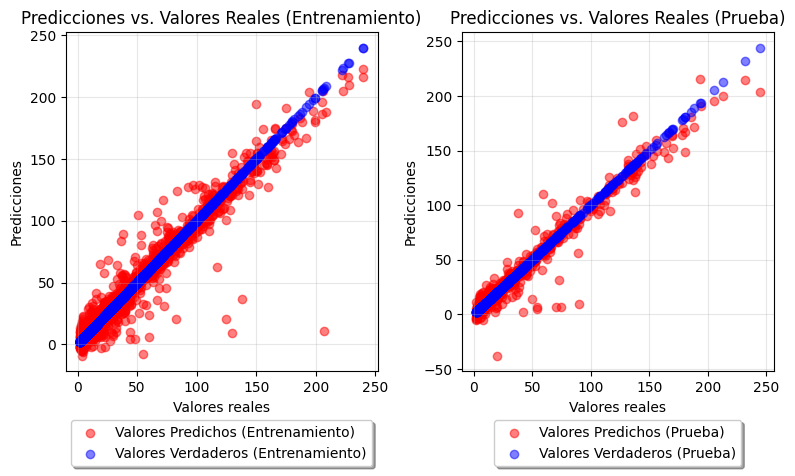

In [ ]:
# SOBRE EL CONJUNTO DE ENTRENAMIENTO:
  # Predecir los valores del conjunto de entrenamiento
y_pred1_train = model.predict(x_constant1)

# SOBRE EL CONJUNTO DE PRUEBA:
 # Predecir los valores del conjunto de prueba
y_pred1_test = model.predict(sm.add_constant(x_test))
modelo_name= '(Modelo 1)'
# llamado a la funcion Metricas:
metricas_mod(modelo_name,y,y_pred1_train,
                    y_test,y_pred1_test)

____________________
## *MODELO 2:*

### *Datos de entrenamiento*

In [ ]:
# ELIMINAR INDICADORES NO SIGNIFICATIVOS:

#columnas a eliminar con p-value > 0.05
colpvalue= ['Short Interest','P/S','Perf Year (%)','Perf Half Y (%)',
            'EPS this Y (%)','Rel Volume','Short Ratio','Beta',
            'Institutional Trans (%)', 'P/C','sector_codes']

#  crear un nuevo conjunto de datos sin las columnas no signicativas
x_pvalue = x[x.columns.difference(colpvalue)]
x_test_pvalue = x_test[x.columns.difference(colpvalue)]

# # Crear x_orig_pvalue con solo las columnas de x_pvalue a partir de x_orig2 p/cv
# x_orig_pvalue = df_sin_outliers[x_pvalue.columns]

#indicadores restantes a evaluar
ind_seleccionados = x_pvalue.columns.tolist()
print(f'Cantidad de indicadores seleccionado:{len(ind_seleccionados)}\n')
ind_seleccionados

Cantidad de indicadores seleccionado:10



['52W High (%)',
 '52W Range Min',
 'Avg Volume',
 'EPS next Y',
 'Institutional Own (%)',
 'Market Cap',
 'Oper-Margin (%)',
 'ROA (%)',
 'Recom',
 'Shs Outstand']

### *Entrenamiento y Resultados*

In [ ]:
# Entrenamiento del modelo
x_constant2 = sm.add_constant(x_pvalue)
model = sm.OLS(y, x_constant2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Target Price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     3635.
Date:                Sat, 25 May 2024   Prob (F-statistic):               0.00
Time:                        07:39:52   Log-Likelihood:                -8229.2
No. Observations:                2235   AIC:                         1.648e+04
Df Residuals:                    2224   BIC:                         1.654e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.2445      0.807     16.420      0.000      11.663      14.826
52W High (%)              0.1465      0.012     12.545      0.000       0.124       0.169
52W Range Min             0.9202      0.008    119.777      0.000       0.905       0.935
Avg Volume              2.52e-09    8.1e-10      3.111      0.002    9.32e-10    4.11e-09
EPS next Y                0.5588      0.085      6.593      0.000       0.393       0.725
Institutional Own (%)    -0.0224      0.008     -2.834      0.005      -0.038      -0.007
Market Cap             9.947e-11   2.75e-11      3.619      0.000    4.56e-11    1.53e-10
Oper-Margin (%)          -0.0037      0.001     -2.717      0.007      -0.006      -0.001
ROA (%)                  -0.0722      0.012     -6.065      0.000      -0.096      -0.049
Recom                    -4.3643      0.289    -15.108      0.000      -4.931      -3.798
Shs Outstand          -2.327e-12   1.98e-12     -1.175      0.240   -6.21e-12    1.56e-12
==============================================================================
Omnibus:                     2697.200   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1019587.806
Skew:                           5.853   Prob(JB):                         0.00
Kurtosis:                     106.979   Cond. No.                     6.12e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.12e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


DESEMPEÑO (Modelo 2):
--------------------------------------------------------------------------------
Sobre el conjunto de entrenamiento

R²: 0.942
Error cuadrático medio (MSE): 92.39
Error absoluto medio (MAE): 4.91

Sobre el conjunto de Prueba

R²: 0.955
Error cuadrático medio (MSE): 82.18
Error absoluto medio (MAE): 4.83

COMPARACIÓN VALORES REALES VS PREDICCIONES
--------------------------------------------------------------------------------


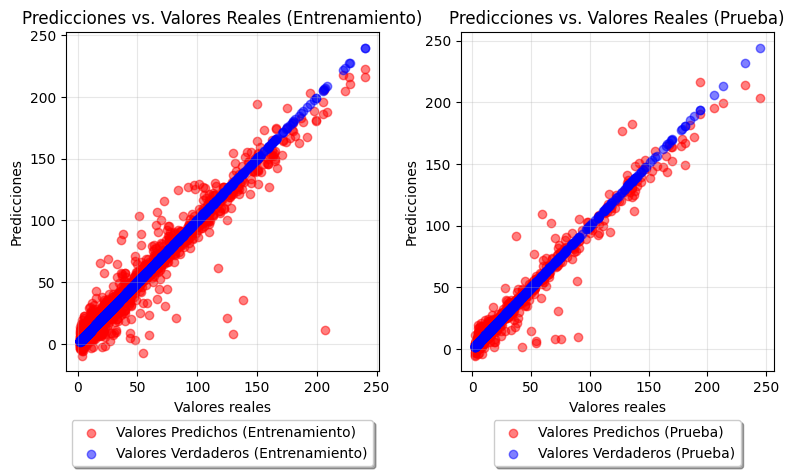

In [ ]:
# Predecir los valores:
# del conjunto de entrenamiento
y_pred2_train = model.predict(x_constant2)
# del conjunto de testeo
y_pred2_test = model.predict(sm.add_constant(x_test_pvalue))
modelo_name= '(Modelo 2)'
# llamado a la funcion Metricas:
metricas_mod(modelo_name,y,y_pred2_train,
                    y_test,y_pred2_test)






> En los graficos se observa el comportamiento de los datos ajustados por el modelo frente a los valores de 'y' verdaderos. Si bien las metricas de desempeño son favorables, se puede observar la dispersion existente e incluso valores que se despegan de forma muy significativa del valor real.



In [ ]:
# Cross Validation del Modelo 2:
# Crear un objeto de regresión lineal
lin_reg = LinearRegression()

# Aplicar cross-validation
cross_validation(lin_reg, x_pvalue, y, cv=5)


Modelo: LinearRegression()

Validación Cruzada con cv = 5

R²:
Promedio de scores (R²): 0.94
Desvío estándar de scores (R²): 0.02

MSE:
Promedio de scores(MSE): 93.85
Desvío estándar de scores (MSE): 54.48


### _Supuestos del Modelo_


**Residuales:**
> La media de los residuales debe ser cercana a 0. Un valor significativamente diferente de 0 podría indicar que el modelo no está bien centrado.


**Prueba de Shapiro-Wilk para la Normalidad de Residuales:**


> El valor p de la prueba de Shapiro-Wilk debe ser superior a 0.05 para no rechazar la hipótesis nula de normalidad de los residuales. Un valor p bajo indica que los residuales no siguen una distribución normal, lo que puede afectar la validez de las inferencias estadísticas.

**Prueba de Breusch-Pagan para la Homocedasticidad:**


>  El valor p de la prueba de Breusch-Pagan debe ser superior a 0.05 para no rechazar la hipótesis nula de homocedasticidad (igualdad de varianza de los residuales). Un valor p bajo indica que la varianza de los residuales no es constante en todos los niveles de las variables independientes, lo que viola el supuesto de homocedasticidad y puede afectar la precisión de las estimaciones.






In [ ]:
# Residuales:
residuales = model.resid
print(f"Media de los residuales: {residuales.mean():.6f}\n")

# Normalidad de residuales y Test Shapiro-Wilk
shapiro_test = stats.shapiro(model.resid)
print(f"Prueba de Shapiro-Wilk (Normalidad): {shapiro_test}\n")

## Aplicacion del test de Breush-Pagan para la igualdad de varianza
   ## (Homocedasticidad)
bp_test = sm.stats.diagnostic.het_breuschpagan(residuales, model.model.exog)
print(f"Test Breush-Pagan, p-value: {bp_test[1]:.6f}")


Media de los residuales: -0.000005

Prueba de Shapiro-Wilk (Normalidad): ShapiroResult(statistic=0.634536623954773, pvalue=0.0)

Test Breush-Pagan, p-value: 0.000011


**Graficos de los supuestos:**

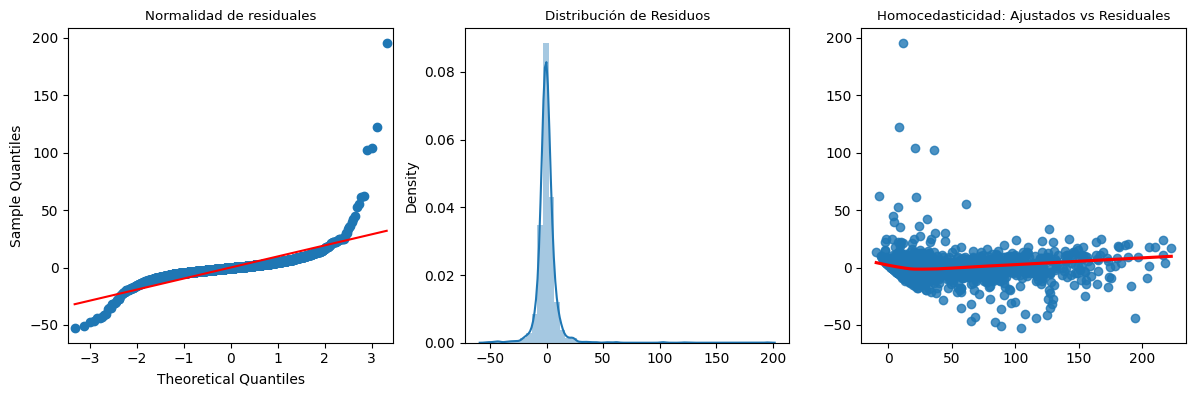

In [ ]:
# Crear una figura de 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12,4))
plt.rc('font', size=8)

# Gráfico 1: Normalidad de residuales
sm.qqplot(residuales, line='s', ax=axes[0])
axes[0].set_title('Normalidad de residuales')

# Gráfico 2: Distplot de residuos
sns.distplot(residuales, kde=True, ax=axes[1])
axes[1].set_title('Distribución de Residuos')

# Gráfico 3: Homocedasticidad: Ajustados vs Residuales
fitted_val = model.predict()
sns.regplot(x=fitted_val, y=residuales, lowess=True,
            line_kws={'color':'red'}, ax=axes[2])
axes[2].set_title('Homocedasticidad: Ajustados vs Residuales')

# Ajustar y mostrar el layout
plt.tight_layout()
plt.show()




> En el grafico 1 y 2 se pueden observar el comportamiento de los valores residuales, tal como se validó en la prueba de Shapiro-Wilk, no siguen una distribución normal.  en el grafico 1 se observan dispersion de residuos tanto en el extremo inferior como en el superior, alejandose de la distribucion normal esperada. En la curva de distribución se observa una deformacion de la distribucion de los datos, con concentracion en el centro, lo cual se puede deber a las relaciones no lineales entre las variables o persistencia de valores atipicos (observaciones extremas).

> En el gráfico 3 se puede observar que la suposición de homocedasticidad no se cumple en este modelo de regresión lineal. Si bien el patron de puntos se distribuye de forma constante en la mayoria de los casos, existen casos que se alejan de forma significativa por encima y por debajo de la línea 0.





# **Random Forest**

##*Datos de entrenamiento*

In [ ]:
#Utilización de los 10 indicadores financieros del modelo 2 de regresion lineal

ind_seleccionados

['52W High (%)',
 '52W Range Min',
 'Avg Volume',
 'EPS next Y',
 'Institutional Own (%)',
 'Market Cap',
 'Oper-Margin (%)',
 'ROA (%)',
 'Recom',
 'Shs Outstand']

In [ ]:
# datos
  ## Se utiliza el dataframe sin outliers
  # Variables independientes
x_orig = df_sin_outliers[ind_seleccionados]

  # Variable target: 'Taget Price'
y_orig = pd.Series(df_sin_outliers['Target Price'])

x1, x_test1, y1, y_test1 = train_test_split(x_orig, y_orig,
                                        test_size=0.25,
                                        random_state=2024)

## *Modelo 1 (Configuración manual de hiperparámetros)*

Modelo Random Forest
Configuración:
1. n_estimators: 150
2. max_depth: 10
3. min_samples_split: 5

DESEMPEÑO (Modelo 1):
--------------------------------------------------------------------------------
Sobre el conjunto de entrenamiento

R²: 0.982
Error cuadrático medio (MSE): 29.01
Error absoluto medio (MAE): 2.57
OOB Score: 0.94

Sobre el conjunto de Prueba

R²: 0.958
Error cuadrático medio (MSE): 75.92
Error absoluto medio (MAE): 4.34

COMPARACIÓN VALORES REALES VS PREDICCIONES
--------------------------------------------------------------------------------


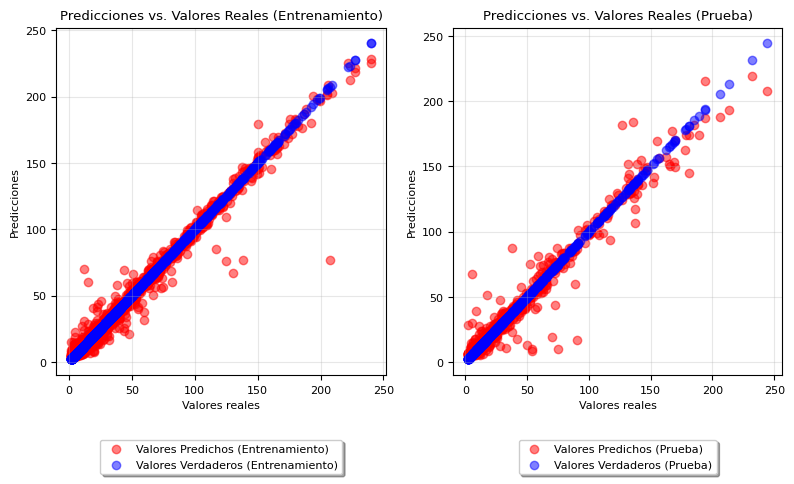


Modelo: RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=150,
                      oob_score=True, random_state=2024)

Validación Cruzada con cv = 5

R²:
Promedio de scores (R²): 0.95
Desvío estándar de scores (R²): 0.02

MSE:
Promedio de scores(MSE): 85.42
Desvío estándar de scores (MSE): 44.35

Tiempo de ejecución: 0.35 minutos

Importancia de las características


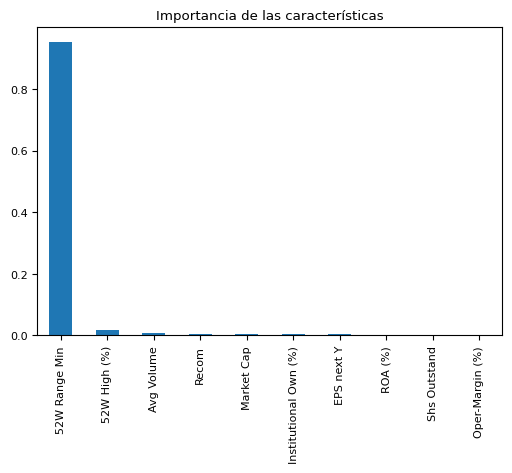

52W Range Min            0.952035
52W High (%)             0.016189
Avg Volume               0.006653
Recom                    0.005586
Market Cap               0.005432
Institutional Own (%)    0.003652
EPS next Y               0.003340
ROA (%)                  0.002480
Shs Outstand             0.002452
Oper-Margin (%)          0.002182
dtype: float64

In [ ]:
# MODELO 1
# Medir el tiempo de inicio
start_time = time.time()

# Establece parametros:
n_estimators= 150
max_depth =10
min_samples_split=5

modelo1 = RandomForestRegressor(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     min_samples_split=min_samples_split,
                                     oob_score= True,
                                     random_state=2024)
modelo1.fit(x1, y1)

# Predecir
y_pred_train1 = modelo1.predict(x1)
y_pred_test1 = modelo1.predict(x_test1)

# Imprimir la mejor configuración y las métricas
print("Modelo Random Forest\nConfiguración:")
print(f'1. n_estimators: {n_estimators}')
print(f'2. max_depth: {max_depth}')
print(f'3. min_samples_split: {min_samples_split}')
oob_score = modelo1.oob_score_
modelo_name= '(Modelo 1)'
# llamado a la funcion Metricas:
metricas_mod(modelo_name,y1, y_pred_train1,
                    y_test1, y_pred_test1,
                    oob_score)



# CROSS VALIDATION:
cross_validation(modelo1,x1, y1,cv=5)

tiempo(start_time,end_time = time.time())


print('\nImportancia de las características')
feature_importances = pd.Series(modelo1.feature_importances_, index=x1.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(6,4))
feature_importances.plot(kind='bar')
plt.title('Importancia de las características')
plt.show()

feature_importances.head(20)

In [ ]:
df_sin_outliers.columns

Index(['52W Range Min', 'ATR (14)', '52W Range Max', '52W High (%)',
       'Shs Outstand', 'Shs Float', 'Short Interest', 'Rel Volume',
       'Avg Volume', 'SMA200 (%)', 'Institutional Trans (%)', 'P/S',
       'Perf Year (%)', 'Perf Half Y (%)', 'EPS this Y (%)', 'EPS next Y',
       'Market Cap', 'ROA (%)', 'Institutional Own (%)', 'Oper-Margin (%)',
       'Recom', 'Short Ratio', 'Beta', 'P/C', 'Target Price', 'sector_codes'],
      dtype='object')

In [ ]:
ind_seleccionados2= ['Market Cap', 'P/S', 'P/C',
                     'EPS this Y (%)','SMA200 (%)', 'Institutional Own (%)',
                     'Institutional Trans (%)',
                     'ROA (%)', 'Oper-Margin (%)', 'Shs Outstand',
                     'Short Ratio', 'Short Interest',
                     'Recom', 'Rel Volume', 'Avg Volume',
                     'Perf Year (%)', 'Beta', 'sector_codes']


# datos
# Variables independientes
x_orig2 = df_sin_outliers[ind_seleccionados2]

# Variable target: 'Target Price'
y_orig2 = pd.Series(df_sin_outliers['Target Price'])

x2, x_test2, y2, y_test2 = train_test_split(x_orig2, y_orig2,
                                        test_size=0.25,
                                        random_state=2024)

## *Modelo 2 (hiperparámetros con GridSearchCV)*

Mejor configuración:
1. n_estimators: 150
2. max_depth: 20
3. min_samples_split: 3

DESEMPEÑO (Modelo 2):
--------------------------------------------------------------------------------
Sobre el conjunto de entrenamiento

R²: 0.976
Error cuadrático medio (MSE): 39.08
Error absoluto medio (MAE): 3.31
OOB Score: 0.84

Sobre el conjunto de Prueba

R²: 0.868
Error cuadrático medio (MSE): 238.58
Error absoluto medio (MAE): 8.36

COMPARACIÓN VALORES REALES VS PREDICCIONES
--------------------------------------------------------------------------------


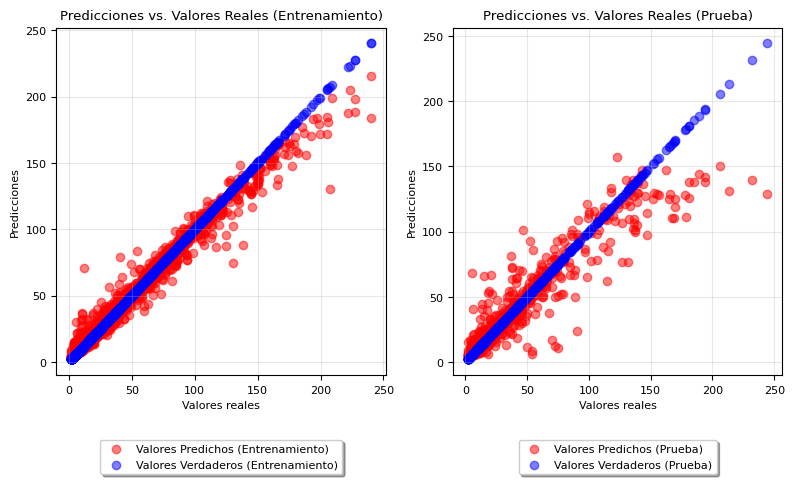


Modelo: RandomForestRegressor(max_depth=20, min_samples_split=3, n_estimators=150,
                      oob_score=True, random_state=2024)

Validación Cruzada con cv = 5

R²:
Promedio de scores (R²): 0.83
Desvío estándar de scores (R²): 0.02

MSE:
Promedio de scores(MSE): 274.99
Desvío estándar de scores (MSE): 66.41

Tiempo de ejecución: 43.78 minutos


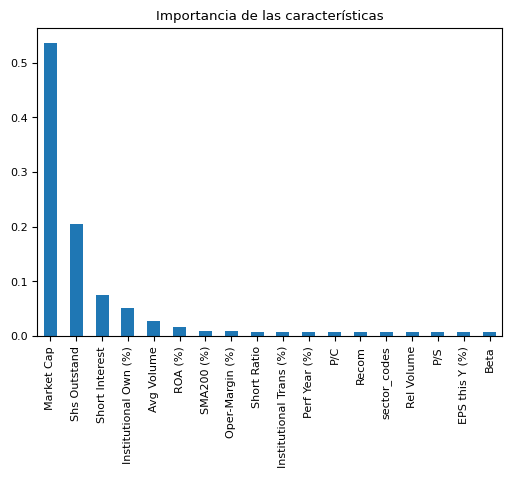

Market Cap                 0.536761
Shs Outstand               0.204974
Short Interest             0.074568
Institutional Own (%)      0.051233
Avg Volume                 0.027409
ROA (%)                    0.017029
SMA200 (%)                 0.009576
Oper-Margin (%)            0.008497
Short Ratio                0.007532
Institutional Trans (%)    0.007358
Perf Year (%)              0.007341
P/C                        0.007300
Recom                      0.007112
sector_codes               0.006973
Rel Volume                 0.006803
P/S                        0.006710
EPS this Y (%)             0.006541
Beta                       0.006282
dtype: float64

In [ ]:
# MODELO 2

# Medir el tiempo de inicio
start_time = time.time()
# Rangos de valores para los hiperparámetros del modelo Random Forest:

param_grid = {
    'n_estimators': [100,150,250,500,1000],
    'max_depth': [5,10,20],
    'min_samples_split': [3, 5, 8,13,15]
}

# Crear el modelo RandomForestRegressor
model_rf = RandomForestRegressor(oob_score=True,random_state=2024)

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model_rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')

# Entrenar GridSearchCV
grid_search.fit(x2, y2)

# Obtener el mejor modelo
modelo2 = grid_search.best_estimator_

# Predecir y calcular métricas con el mejor modelo
y_pred_train2 = modelo2.predict(x2)
y_pred_test2 = modelo2.predict(x_test2)

# Almacenar métricas en un diccionario
best_metrics = {
    "n_estimators": modelo2.n_estimators,
    "max_depth": modelo2.max_depth,
    "min_samples_split": modelo2.min_samples_split,}

# Imprimir la mejor configuración y las métricas
print("Mejor configuración:")
print('\n'.join([f'{i+1}. {key}: {value}'
                 for i, (key, value) in enumerate(best_metrics.items())]))

oob_score2 = modelo2.oob_score_
modelo_name= '(Modelo 2)'
# llamado a la funcion Metricas:

# llamado a la funcion Metricas:
metricas_mod(modelo_name,y2, y_pred_train2,
                    y_test2, y_pred_test2,oob_score2)

cross_validation(modelo2, x2, y2, cv=5)

# Medir el tiempo de finalización
tiempo(start_time,end_time = time.time())

feature_importances = pd.Series(modelo2.feature_importances_, index=x2.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
feature_importances.plot(kind='bar')
plt.title('Importancia de las características')
plt.show()

feature_importances.head(20)


# **XGBOOST**

## *Modelo*

###*Datos de entrenamiento*

In [ ]:
# datos
  ## Se utiliza el dataframe sin outliers:
x_orig = df_sin_outliers.drop(['Target Price'], axis=1)

y_orig = pd.Series(df_sin_outliers['Target Price'])
  ## Muestreo
x_train, x_test, y_train, y_test = train_test_split(x_orig, y_orig,
                                        test_size=0.25,
                                        random_state=2024)

In [ ]:
print(f'Cantidad de indicadores seleccionados:{df_sin_outliers.shape[1]}\n')
df_sin_outliers.columns

Cantidad de indicadores seleccionados:26



Index(['52W Range Min', 'ATR (14)', '52W Range Max', '52W High (%)',
       'Shs Outstand', 'Shs Float', 'Short Interest', 'Rel Volume',
       'Avg Volume', 'SMA200 (%)', 'Institutional Trans (%)', 'P/S',
       'Perf Year (%)', 'Perf Half Y (%)', 'EPS this Y (%)', 'EPS next Y',
       'Market Cap', 'ROA (%)', 'Institutional Own (%)', 'Oper-Margin (%)',
       'Recom', 'Short Ratio', 'Beta', 'P/C', 'Target Price', 'sector_codes'],
      dtype='object')

###*Selección automática de variables mediante RFECV*

Se Aplica "Eliminación Recursiva de Características con Validación Cruzada" (RFECV), como técnica de selección de características

In [ ]:
# Creación del Modelo XGBoost
modelo = xgb.XGBRegressor(random_state=2024,enable_categorical=True)
# Configuración de RFECV
selector = RFECV(modelo,step=3,min_features_to_select=5,cv=5)
# Ajuste de RFECV
selector.fit(x_train, y_train)
# DataFrame de Resultados
df_indic_sel = pd.DataFrame({'indicador':x_train.columns,
                             'ranking':selector.ranking_})
df_indic_sel.sort_values(by='ranking',ascending=True).reset_index(drop=True)
# Seleccionar los valores de 'indicador' donde 'ranking' es igual a 1
ind_seleccionados3 = df_indic_sel[df_indic_sel['ranking'] == 1]['indicador'].tolist()
# Mostrar los indicadores que se van a usar
print(f'Cantidad de indicadores seleccionados mediante RFECV:{len(ind_seleccionados3)}')
ind_seleccionados3


Cantidad de indicadores seleccionados mediante RFECV:25


['52W Range Min',
 'ATR (14)',
 '52W Range Max',
 '52W High (%)',
 'Shs Outstand',
 'Shs Float',
 'Short Interest',
 'Rel Volume',
 'Avg Volume',
 'SMA200 (%)',
 'Institutional Trans (%)',
 'P/S',
 'Perf Year (%)',
 'Perf Half Y (%)',
 'EPS this Y (%)',
 'EPS next Y',
 'Market Cap',
 'ROA (%)',
 'Institutional Own (%)',
 'Oper-Margin (%)',
 'Recom',
 'Short Ratio',
 'Beta',
 'P/C',
 'sector_codes']

### *Ajuste de datos de entrenamiento*

In [ ]:
# datos
  ## Se utiliza el dataframe sin outliers:
x_orig = df_sin_outliers.drop(['Target Price'], axis=1)
 ## Se utilizan los indicadores seleccionados mediante RFECV
x_orig= x_orig[ind_seleccionados3]
y_orig = pd.Series(df_sin_outliers['Target Price'])
  ## Muestreo
x_train, x_test, y_train, y_test = train_test_split(x_orig, y_orig,
                                        test_size=0.25,
                                        random_state=2024)

### *Entrenamiento y Resultados*

Modelo XGBOOST:
Mejores Parametros encontrados:
1. colsample_bytree: 0.5
2. eval_metric: rmse
3. gamma: 0
4. learning_rate: 0.01
5. max_depth: 15
6. min_child_weight: 5
7. n_estimators: 500
8. objective: reg:squarederror
9. subsample: 0.6

DESEMPEÑO (Modelo 1):
--------------------------------------------------------------------------------
Sobre el conjunto de entrenamiento

R²: 0.975
Error cuadrático medio (MSE): 40.35
Error absoluto medio (MAE): 3.48

Sobre el conjunto de Prueba

R²: 0.955
Error cuadrático medio (MSE): 82.06
Error absoluto medio (MAE): 5.16

COMPARACIÓN VALORES REALES VS PREDICCIONES
--------------------------------------------------------------------------------


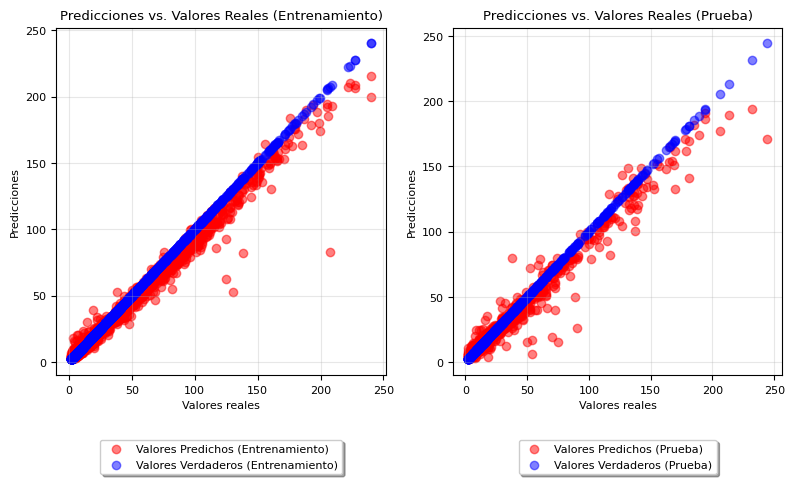



Validación Cruzada con cv = 5

R²:
Promedio de scores (R²): 0.95
Desvío estándar de scores (R²): 0.02

MSE:
Promedio de scores(MSE): 78.9
Desvío estándar de scores (MSE): 47.91

Tiempo de ejecución: 18.22 minutos


In [ ]:
# Medir el tiempo de inicio
start_time = time.time()
# Parámetros del modelo XGBoost
parametros = {
    'objective': ['reg:squarederror'],  # Metrica R2
    'n_estimators': [100,200,500],      # Numero de arboles
    'max_depth': [5,10,15],             # Profundidad máxima de los arboles
    'subsample': [0.6,0.8],             # % de muestras utilizadas en cada árbol
    'colsample_bytree': [0.5],          # % de características utilizadas en cada árbol
    'learning_rate': [0.01,0.1],        # Tasa de aprendizaje
    'gamma':  [0],                      # Parametro de regularización
    'min_child_weight': [1, 5],         # Peso mínimo de las muestras en un nodo hijo
    'eval_metric': ['rmse']
}

# Crear el modelo XGBoost con los parametros seleccionados
model = xgb.XGBRegressor(random_state=2024,enable_categorical=True)

grid= GridSearchCV(model,
                   param_grid=parametros,
                   cv=5,
                   return_train_score=True)

# Entrenar el modelo
grid.fit(x_train.values, y_train.values)

# Obtener el mejor modelo
best_model = grid.best_estimator_
# Obtener los mejores parametros
best_params = grid.best_params_
# Puntaje promedio de validación cruzada del mejor modelo.
best_scores= grid.best_score_
# # Nombres de las características utilizadas en el entrenamiento.
# features_names = x_train.columns

# Predecir y calcular métricas
# Make predictions on the test data (assuming x_test and y_test are available)

y_pred_train= best_model.predict(x_train)
y_pred_test = best_model.predict(x_test)

print("Modelo XGBOOST:\nMejores Parametros encontrados:")
print('\n'.join([f'{i+1}. {key}: {value}'
                 for i, (key, value) in enumerate(best_params.items())]))
modelo_name= '(Modelo 1)'
# llamado a la funcion Metricas:
metricas_mod(modelo_name,y_train,y_pred_train,
                    y_test,y_pred_test)
cross_validation(best_model, x_train, y_train, cv=5)

# Medir tiempo de ejecucion:
tiempo(start_time,end_time = time.time())

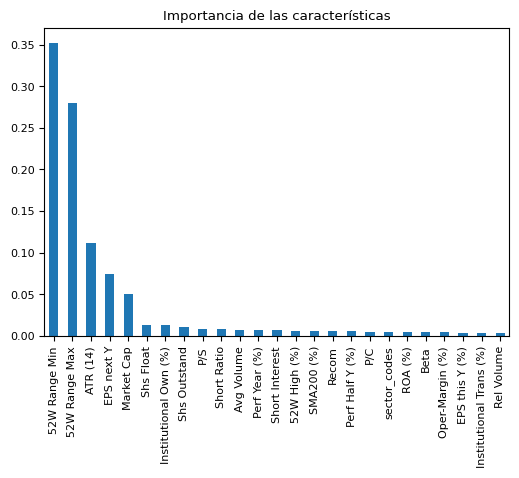

52W Range Min            0.352336
52W Range Max            0.279770
ATR (14)                 0.111069
EPS next Y               0.074714
Market Cap               0.050577
Shs Float                0.013046
Institutional Own (%)    0.012817
Shs Outstand             0.010966
P/S                      0.008406
Short Ratio              0.007885
Avg Volume               0.007435
Perf Year (%)            0.007157
Short Interest           0.006663
52W High (%)             0.006260
SMA200 (%)               0.006020
Recom                    0.005988
Perf Half Y (%)          0.005540
P/C                      0.005168
sector_codes             0.004770
ROA (%)                  0.004603
dtype: float32

In [ ]:
feature_importances = pd.Series(best_model.feature_importances_,
                                index=x_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(6, 4))
feature_importances.plot(kind='bar')
plt.title('Importancia de las características')
plt.show()

feature_importances.head(20)